# Importación de librerías

In [58]:
import numpy as np
import pandas as pd
import os
import csv
import random
from PIL import Image
from skimage.transform import resize

from tensorflow import keras

import matplotlib.pyplot as plt

# Carga de Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lectura de los datos

In [3]:
# Carga de los dataframes de train, test y validation
df_train = pd.read_csv("/content/drive/MyDrive/TFM/train_labels.csv")
df_test = pd.read_csv("/content/drive/MyDrive/TFM/test_labels.csv")
df_validation = pd.read_csv("/content/drive/MyDrive/TFM/validation_labels.csv")

print("El número de registros en df_train es: " + str(len(df_train)))
print("El número de registros en df_test es: " + str(len(df_test)))
print("El número de registros en df_validation es: " + str(len(df_validation)))

El número de registros en df_train es: 32144
El número de registros en df_test es: 3000
El número de registros en df_validation es: 3000


In [4]:
df_train.head()

,PatientId,Target
0,f2e8cacc-b217-4e82-93ba-33bf5e04e94c,1
1,4b46098e-ea85-41de-9534-0a645ec9b121,0
2,dee054ff-0e1a-4167-b814-cbf339cf689c,0
3,d798aa5b-28ef-463e-81a1-c05c83dcdebb,0
4,2e13eff6-7bb4-4b45-846f-1522888dbfe1,1


In [5]:
df_test.head()

,PatientId,Target
0,49f0fa25-89cd-41a7-9c70-4d7d8d9be572,1
1,eb10b7c7-fc94-488a-a5a9-704876d78ebb,1
2,c56b1137-e4d4-4139-94ba-b287ca43e318,0
3,17f68ac3-2385-4b13-b8c0-66ba8b343205,1
4,0c89ca38-27ca-4cd0-88cb-18093fdcb04b,1


In [6]:
df_validation.head()

,PatientId,Target
0,b35d57ee-f22b-4c8c-b959-3ee8eecef555,1
1,09ea637f-0f6a-427e-8dad-858330a2498e,0
2,0cbc601f-91f0-4f86-b780-ffeac24471c7,1
3,47d188c2-6a54-4548-975e-85a63643b08b,0
4,172f8b71-1d19-4a36-ae9f-41ae528c72be,1


## Comprobación de los datos

Vamos a comprobar que las imágenes que se encuentran en cada directorio, es decir, en train, validation, y test, también están en los dataframes correspondientes.

Se hace esta comprobación básicamente para saber si se han subido de forma correcta las imágenes.

In [7]:
def check_images(dir, df):
  files = os.listdir(dir)
  num_elements = len(df)
  num_images = len(files)

  # Recorremos el dataframe correspondiente y comprobamos si están las imágenes
  for patientId in df["PatientId"]:
    if not patientId + ".png" in files:
      return False

  # Comprobamoos que hay el mismo número de registros que de imágenes
  if num_elements != num_images:
    return False

  return True

In [9]:
print("Train: " + str(check_images("/content/drive/MyDrive/TFM/train_images", df_train)))
print("Test: " + str(check_images("/content/drive/MyDrive/TFM/test_images", df_test)))
print("Validation: " + str(check_images("/content/drive/MyDrive/TFM/validation_images", df_validation)))

Train: True
Test: True
Validation: True


# Data Generator

En este punto vamos a resolver la problemática de la carga de los datos en memoria. El dataset de entrenamiento presenta 32144 imágenes con resolución 1024x1024, lo cual hace que haya un elevado consumo de memoria, hasta tal punto que puede que Google Colab no sea capaz de soportar.

Para solventar este problema creamos un data generator, el cual se encarga de cargar en memoria pequeños grupos de imágenes según se vayan utilizando, es decir, dependiendo del tamaño del batch.

La salida que proporciona el data generator es un cojunto de imágenes junto con la variable objetivo.


In [65]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):

  # Constructor
  def __init__(self, folder, batch_size=32, image_size=256, shuffle=True, predict=False):
    self.folder = folder
    self.filenames = os.listdir(folder)
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.predict = predict
    self.on_epoch_end()
    

  # Carga y Transformación de la imágenes para training
  # filename: es el nombre del archivo de la imagen, es decir, con png
  def __train__(self, filename):
    # Cargamos la imagen original
    img = np.array(Image.open(os.path.join(self.folder, filename)))

    # Cargamos la variable objetivo
    target = df_train[df_train["PatientId"] == filename.split(".")[0]]["Target"].item()

    # Reducción de la escala de la imagen
    img = resize(img, (self.image_size, self.image_size), mode="reflect")

    # Normalizamos
    img_min = img.min()
    img_max = img.max()
    img_norm = (img - img_min) / (img_max - img_min)

    # Expandimos las dimensiones (self.image_size, self.image_size, 1)
    img_norm = np.expand_dims(img_norm, -1)

    return img_norm, target


  # Carga y transformación de las imágenes para testing
  def __test__(self, filename):
    # Cargamos la imagen original
    img = np.array(Image.open(os.path.join(self.folder, filename)))

    # Reducción de la escala de la imagen
    img = resize(img, (self.image_size, self.image_size), mode="reflect")

    # Normalizamos
    img_min = img.min()
    img_max = img.max()
    img_norm = (img - img_min) / (img_max - img_min)

    # Expandimos las dimensiones (self.image_size, self.image_size, 1)
    img_norm = np.expand_dims(img_norm, -1)

    return img_norm

  
  # Método encargado de generar el batch
  def __getitem__(self, index):
    # Generación de los nombres de archivos pertenecientes al batch
    filenames_batch = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

    if self.predict:
      # Modo testing
      imgs = [self.__test__(filename) for filename in filenames_batch]
      imgs = np.array(imgs)
      return imgs, filenames_batch

    else:
      # Modo training
      items = [self.__train__(filename) for filename in filenames_batch]
      imgs, targets = zip(*items)
      imgs = np.array(imgs)
      targets = np.array(targets)
      return imgs, targets

  # Método encargado de mezclar nos nombres de archivos, para así dotar de una mayor aleatoriedad
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.filenames)

  # Método para controlar el tamaño del 
  def __len__(self):
    return int(np.floor(len(self.filenames) / self.batch_size))

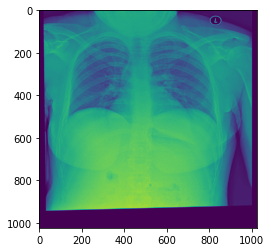

In [39]:
img = np.array(Image.open(os.path.join("/content/drive/MyDrive/TFM/train_images", "000924cf-0f8d-42bd-9158-1af53881a557.png")))
plt.imshow(img)

1004
1004
